In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    ''' Здесь придумайте какой-нибудь свой пример с данными по аналогии с гауссинками и проверьте алгоритмы на них '''
    # Пример: смесь двух гауссианов (bimodal distribution)
    # logp(x) = log(0.5 * N(x|mu1, I) + 0.5 * N(x|mu2, I))
    mu1 = np.array([-2.0, -2.0] + [0.0] * (len(x) - 2))
    mu2 = np.array([2.0, 2.0] + [0.0] * (len(x) - 2))
    
    logp1 = -0.5 * np.dot(x - mu1, x - mu1)
    logp2 = -0.5 * np.dot(x - mu2, x - mu2)
    
    max_log = max(logp1, logp2)
    logp_mix = max_log + np.log(0.5 * np.exp(logp1 - max_log) + 0.5 * np.exp(logp2 - max_log))
    
    return logp_mix

def grad_your_data_utils(x):
    ''' Градиент для вашего примера данных '''
    mu1 = np.array([-2.0, -2.0] + [0.0] * (len(x) - 2))
    mu2 = np.array([2.0, 2.0] + [0.0] * (len(x) - 2))
    
    logp1 = -0.5 * np.dot(x - mu1, x - mu1)
    logp2 = -0.5 * np.dot(x - mu2, x - mu2)
    
    # Log-sum-exp trick
    max_log = max(logp1, logp2)
    exp1 = np.exp(logp1 - max_log)
    exp2 = np.exp(logp2 - max_log)
    total = 0.5 * exp1 + 0.5 * exp2
    
    # Градиент смеси
    grad1 = -(x - mu1)
    grad2 = -(x - mu2)
    
    grad_mix = (0.5 * exp1 * grad1 + 0.5 * exp2 * grad2) / total
    
    return grad_mix

In [3]:
''' Рассчет ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale, logp_func=logp):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp_func(prop) - logp_func(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step, logp_func=logp, grad_logp_func=grad_logp):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        # MALA
        grad = grad_logp_func(x)
        z = rng.normal(0, 1, size=d)
        prop = x + (step / 2) * grad + np.sqrt(step) * z
        
        grad_prop = grad_logp_func(prop)
        
        # Forward
        forward_diff = prop - x - (step / 2) * grad
        forward_logq = -0.5 / step * np.dot(forward_diff, forward_diff)
        
        # Reverse
        reverse_diff = x - prop - (step / 2) * grad_prop
        reverse_logq = -0.5 / step * np.dot(reverse_diff, reverse_diff)
        
        log_alpha = logp_func(prop) - logp_func(x) + reverse_logq - forward_logq
        
        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [12]:
# Эксперимент 1: Изотропное нормальное распределение N(0, I_d)
print("=" * 60)
print("Эксперимент 1: Изотропное нормальное распределение N(0, I_d)")
print("=" * 60)

d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

# Подбираем параметры для хорошего acceptance rate (~0.5-0.6 для MALA, ~0.2-0.4 для MH)
mala_step = 0.5  # шаг для MALA
mh_scale = 1.0   # скейл для пропозала в MH

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

# Обрезаем burn-in
mh_chain_burned = mh_chain[burn:]
mala_chain_burned = mala_chain[burn:]

# Вычисляем ESS для каждой размерности
mh_ess_per_dim = [ess(mh_chain_burned[:, i]) for i in range(d)]
mala_ess_per_dim = [ess(mala_chain_burned[:, i]) for i in range(d)]

print(f"MH - Acceptance rate: {mh_acc:.4f}")
print(f"MH - Медианный ESS: {np.median(mh_ess_per_dim):.2f}")
print(f"MALA - Acceptance rate: {mala_acc:.4f}")
print(f"MALA - Медианный ESS: {np.median(mala_ess_per_dim):.2f}")

# Сохраняем результаты для визуализации
gaussian_results = {
    'mh_chain': mh_chain_burned,
    'mala_chain': mala_chain_burned,
    'mh_acc': mh_acc,
    'mala_acc': mala_acc,
    'mh_ess': np.median(mh_ess_per_dim),
    'mala_ess': np.median(mala_ess_per_dim)
}

# Эксперимент 2: Смесь двух гауссианов
print("\n" + "=" * 60)
print("Эксперимент 2: Смесь двух гауссианов (bimodal)")
print("=" * 60)

d2 = 10
x0_2 = np.zeros(d2)  # стартуем в нуле

# Для смеси гауссианов нужны другие параметры
mala_step_2 = 0.3
mh_scale_2 = 0.8

mh_chain_2, mh_acc_2 = mh(x0_2, steps, scale=mh_scale_2, logp_func=your_data_utils)
mala_chain_2, mala_acc_2 = mala(
    x0_2, 
    steps, 
    step=mala_step_2, 
    logp_func=your_data_utils, 
    grad_logp_func=grad_your_data_utils
    )

# Обрезаем burn-in
mh_chain_2_burned = mh_chain_2[burn:]
mala_chain_2_burned = mala_chain_2[burn:]

# Вычисляем ESS для каждой размерности
mh_ess_per_dim_2 = [ess(mh_chain_2_burned[:, i]) for i in range(d2)]
mala_ess_per_dim_2 = [ess(mala_chain_2_burned[:, i]) for i in range(d2)]

print(f"MH - Acceptance rate: {mh_acc_2:.4f}")
print(f"MH - Медианный ESS: {np.median(mh_ess_per_dim_2):.2f}")
print(f"MALA - Acceptance rate: {mala_acc_2:.4f}")
print(f"MALA - Медианный ESS: {np.median(mala_ess_per_dim_2):.2f}")

# Сохраняем результаты для визуализации
mixture_results = {
    'mh_chain': mh_chain_2_burned,
    'mala_chain': mala_chain_2_burned,
    'mh_acc': mh_acc_2,
    'mala_acc': mala_acc_2,
    'mh_ess': np.median(mh_ess_per_dim_2),
    'mala_ess': np.median(mala_ess_per_dim_2)
}

Эксперимент 1: Изотропное нормальное распределение N(0, I_d)
MH - Acceptance rate: 0.1422
MH - Медианный ESS: 677.28
MALA - Acceptance rate: 0.8913
MALA - Медианный ESS: 3541.46

Эксперимент 2: Смесь двух гауссианов (bimodal)
MH - Acceptance rate: 0.2366
MH - Медианный ESS: 772.81
MALA - Acceptance rate: 0.9488
MALA - Медианный ESS: 2208.21


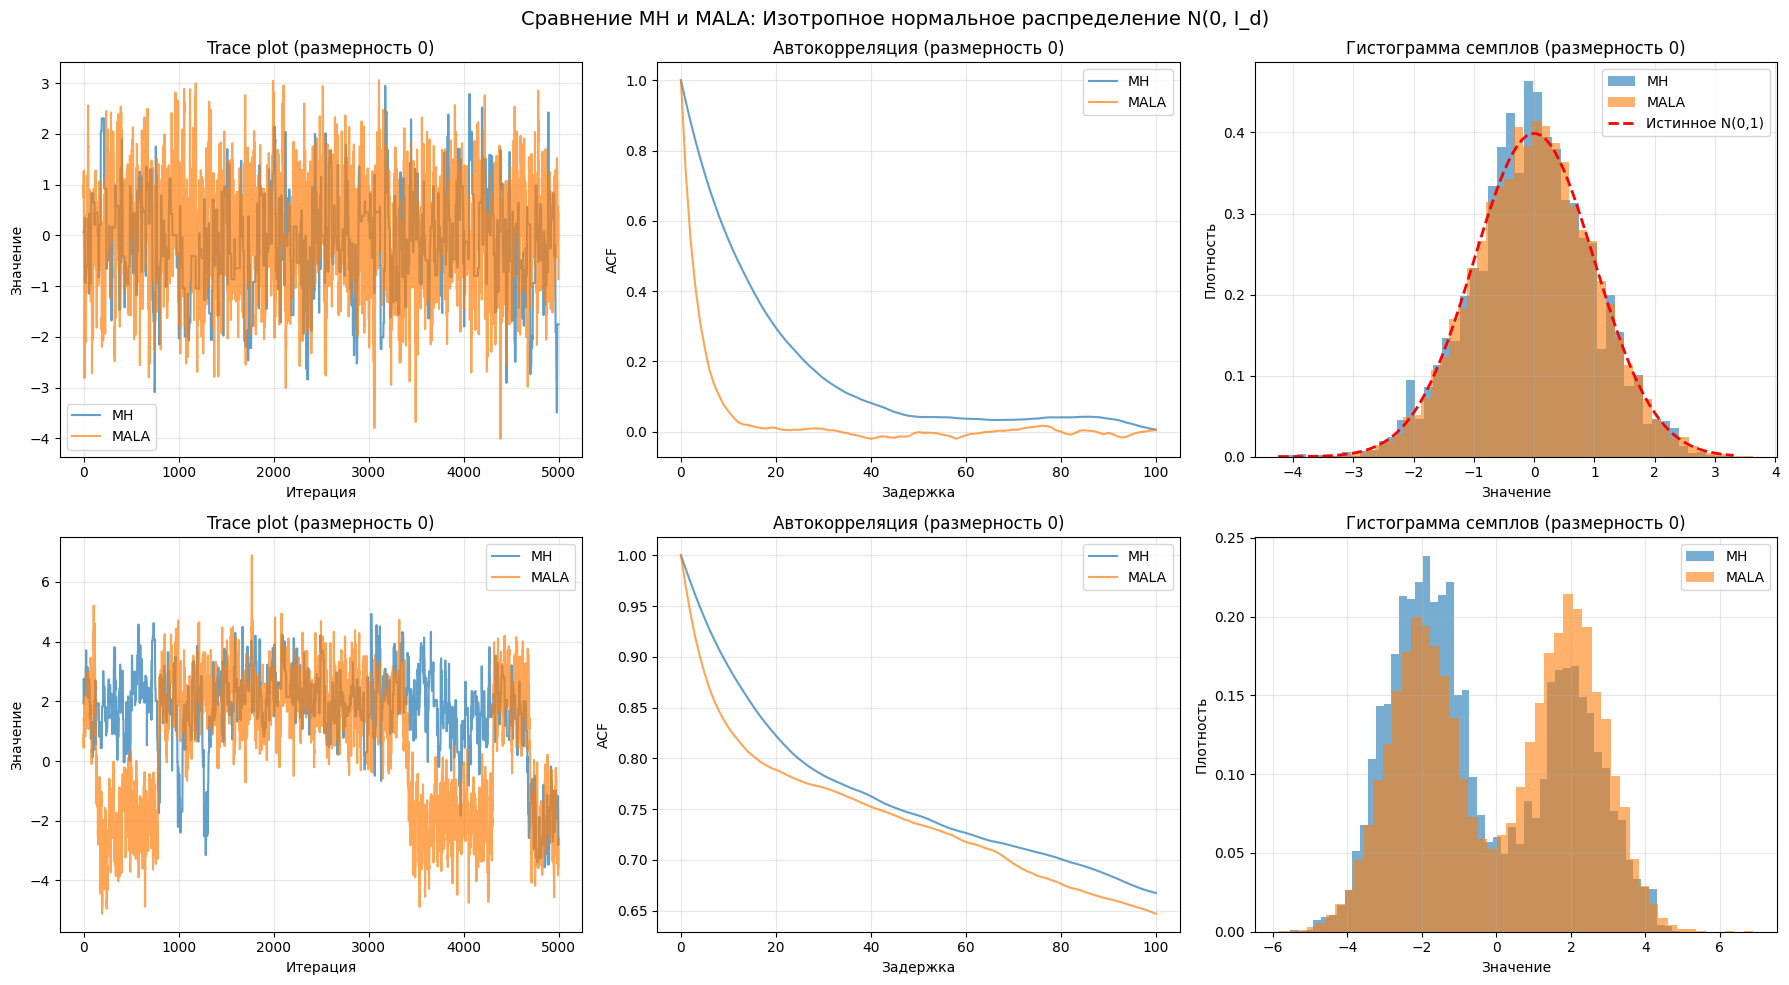

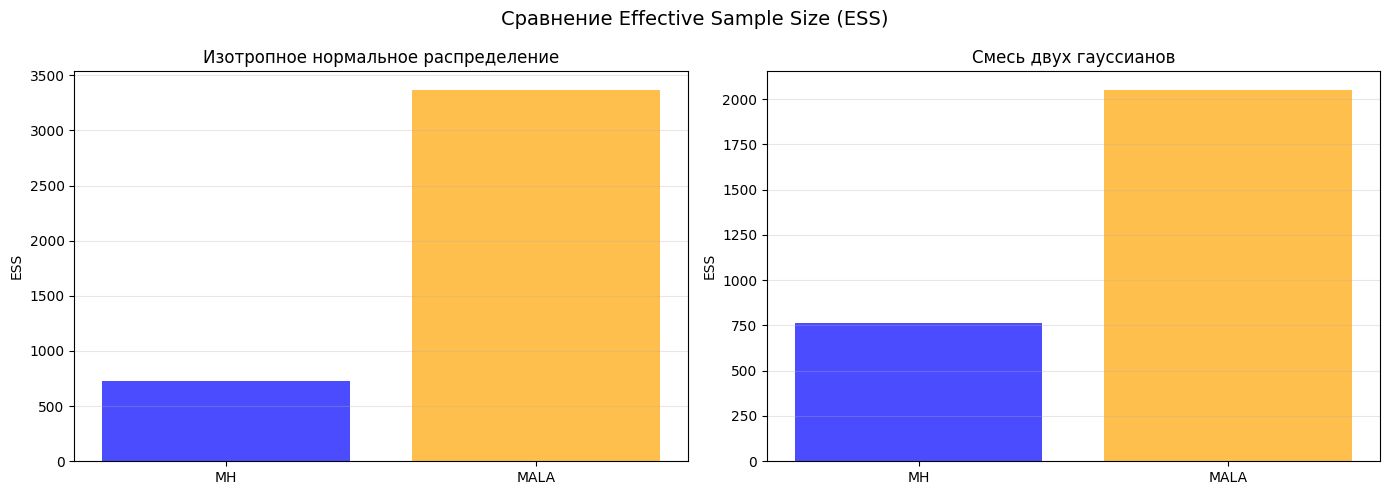

In [7]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

def compute_acf(x, max_lag=200):
    """Вычисляет автокорреляционную функцию"""
    x = x - x.mean()
    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf = acf[:max_lag+1]
    acf /= acf[0]
    return acf

# Графики для эксперимента 1: Изотропное нормальное распределение
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Сравнение MH и MALA: Изотропное нормальное распределение N(0, I_d)', fontsize=14)

dim_idx = 0  # Берем первую размерность для визуализации

# Trace plots
axes[0, 0].plot(mh_chain_burned[:, dim_idx][:5000], alpha=0.7, label='MH')
axes[0, 0].plot(mala_chain_burned[:, dim_idx][:5000], alpha=0.7, label='MALA')
axes[0, 0].set_xlabel('Итерация')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title(f'Trace plot (размерность {dim_idx})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Autocorrelation
max_lag = 100
lags = np.arange(max_lag + 1)
mh_acf = compute_acf(mh_chain_burned[:, dim_idx], max_lag)
mala_acf = compute_acf(mala_chain_burned[:, dim_idx], max_lag)

axes[0, 1].plot(lags, mh_acf, alpha=0.7, label='MH')
axes[0, 1].plot(lags, mala_acf, alpha=0.7, label='MALA')
axes[0, 1].set_xlabel('Задержка')
axes[0, 1].set_ylabel('ACF')
axes[0, 1].set_title(f'Автокорреляция (размерность {dim_idx})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Histogram
axes[0, 2].hist(mh_chain_burned[:, dim_idx], bins=50, alpha=0.6, label='MH', density=True)
axes[0, 2].hist(mala_chain_burned[:, dim_idx], bins=50, alpha=0.6, label='MALA', density=True)
# Истинное распределение N(0, 1)
x_true = np.linspace(mh_chain_burned[:, dim_idx].min(), mh_chain_burned[:, dim_idx].max(), 100)
axes[0, 2].plot(x_true, np.exp(-0.5 * x_true**2) / np.sqrt(2 * np.pi), 'r--', linewidth=2, label='Истинное N(0,1)')
axes[0, 2].set_xlabel('Значение')
axes[0, 2].set_ylabel('Плотность')
axes[0, 2].set_title(f'Гистограмма семплов (размерность {dim_idx})')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Графики для эксперимента 2: Смесь двух гауссианов
dim_idx_2 = 0  # Берем первую размерность для визуализации

# Trace plots
axes[1, 0].plot(mh_chain_2_burned[:, dim_idx_2][:5000], alpha=0.7, label='MH')
axes[1, 0].plot(mala_chain_2_burned[:, dim_idx_2][:5000], alpha=0.7, label='MALA')
axes[1, 0].set_xlabel('Итерация')
axes[1, 0].set_ylabel('Значение')
axes[1, 0].set_title(f'Trace plot (размерность {dim_idx_2})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Autocorrelation
mh_acf_2 = compute_acf(mh_chain_2_burned[:, dim_idx_2], max_lag)
mala_acf_2 = compute_acf(mala_chain_2_burned[:, dim_idx_2], max_lag)

axes[1, 1].plot(lags, mh_acf_2, alpha=0.7, label='MH')
axes[1, 1].plot(lags, mala_acf_2, alpha=0.7, label='MALA')
axes[1, 1].set_xlabel('Задержка')
axes[1, 1].set_ylabel('ACF')
axes[1, 1].set_title(f'Автокорреляция (размерность {dim_idx_2})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Histogram
axes[1, 2].hist(mh_chain_2_burned[:, dim_idx_2], bins=50, alpha=0.6, label='MH', density=True)
axes[1, 2].hist(mala_chain_2_burned[:, dim_idx_2], bins=50, alpha=0.6, label='MALA', density=True)
axes[1, 2].set_xlabel('Значение')
axes[1, 2].set_ylabel('Плотность')
axes[1, 2].set_title(f'Гистограмма семплов (размерность {dim_idx_2})')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительный график: сравнение ESS
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
fig2.suptitle('Сравнение Effective Sample Size (ESS)', fontsize=14)

# ESS для эксперимента 1
axes2[0].bar(['MH', 'MALA'], [gaussian_results['mh_ess'], gaussian_results['mala_ess']], color=['blue', 'orange'], alpha=0.7)
axes2[0].set_ylabel('ESS')
axes2[0].set_title('Изотропное нормальное распределение')
axes2[0].grid(True, alpha=0.3, axis='y')

# ESS для эксперимента 2
axes2[1].bar(['MH', 'MALA'], [mixture_results['mh_ess'], mixture_results['mala_ess']], color=['blue', 'orange'], alpha=0.7)
axes2[1].set_ylabel('ESS')
axes2[1].set_title('Смесь двух гауссианов')
axes2[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [9]:
## Выводы

# Эксперимент 1 (Изотропное нормальное распределение):** MALA показывает лучшие результаты по сравнению с MH благодаря использованию градиентной информации, что позволяет делать более направленные предложения и быстрее исследовать пространство параметров. Это выражается в более высоком ESS и более быстрой сходимости автокорреляции к нулю.

# Эксперимент 2 (Смесь двух гауссианов):** На мультимодальном распределении MALA также превосходит MH, так как градиент помогает алгоритму эффективнее перемещаться между модами и лучше исследовать сложное пространство параметров. Однако разница может быть менее выраженной из-за сложности распределения и необходимости перепрыгивать между модами.
